# **Description**
In this notebook we want to classifiy set of user messages about stock market.
Our data is persian text and we GLOVE embedding to vectorize messages.



In [ ]:
!pip install hazm
!pip install parsivar
!pip install fasttext
!pip install gensim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels_to_id = {0:0,
               "question":1,
                "news":2,
                "new":2,
                "news_official":2,
                'news_offcial':2,
                "analysis_technical":3,
                "analysis_fun":3,
                "analysis":3,
                "buy":4,
                "buy_lc":4,
                "predict+":5,
                "predict-":6,
                "sell":7,
                "report_st":8,
                "report_loss":9,
                "report_profit":10,
                'predict_profit':10,
                "report_per":11,
                "hold":12,
                "watch":13,
                "take_profit":14,
                "statistics":15,
                }
id_2_labels = {0:0,
               1:"question",
               2: "news",
              3:"analysis",
              4 : "buy",
                5:"predict+",
                6:"predict-",
                7:"sell",
                8:"report_st",
                9:"report_loss",
                10:"report_profit",
                11:"report_per",
                12:"hold",
                13:"watch",
                14:"take_profit",
                15:"statistics",
                }

# stop_words = {""}
num_of_class = 16
max_len = 30

In [ ]:
import os
os.chdir("/content/drive/MyDrive/master_project")

In [ ]:
# p = "/content/drive/MyDrive/master_project/Persian-stopwords-collection/Stopwords"
# l_f = os.listdir(p)
# print(l_f)
# stop_list = []
# for f in l_f:
#   f = p +"/"+ f
#   file_addrs = os.listdir(f)[0]
#   stop_list += open(f + "/" + file_addrs).read().split("\n")
# print(len(stop_list))
# len(np.unique(np.array(stop_list)))

# data preparation

In [ ]:
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset,DataLoader

from hazm import Normalizer, WordTokenizer
from parsivar import FindStems,POSTagger, Tokenizer
from gensim.models import Word2Vec,TfidfModel, LdaModel
from gensim.corpora import Dictionary


In [ ]:
import math
class Data_load():
    def __init__(self,max_len ):
          self.max_len = max_len
          self.sentence_embedding = []
          self.dictionary = None
          self.BoW_corpus = None
          self.load_vector()
          print(len(self.vocab_vector['و']))
    def load_vector(self ):
        self.vocab_vector = {}
        str_vector = open("/content/drive/MyDrive/master_project/glove-vectors-farsi-dedup.txt").read().split("\n")
        for vec in str_vector:
          vec_terms = vec.split(" ")
          self.vocab_vector[vec_terms[0]] = list(map(lambda x: float(x), vec_terms[1:]))

    def load_data(self):
      messages_file = pd.read_excel("/content/drive/MyDrive/master_project/classification_data/clean_data_new3.xlsx")
      messages_file.dropna(subset=['label'])
      nrmlizr = Normalizer()
      tokenizer =  Tokenizer()
      stemmer = FindStems()
      tagger = POSTagger(tagging_model="wapiti")
      print(len(messages_file))
      l = 0
      docs = []
      for i in range(len(messages_file)):

          vocab = []
          words = tagger.parse(tokenizer.tokenize_words(nrmlizr.normalize(messages_file.loc[i, "message"])))
          clean_words = []
          for w in words:
            w[0] == w[0].strip("\u200c").strip("\u200e")

            if w[1] not in ["V_AUX","V_PA","V_PRE", "V_PRS", "V_SUB"] and len(w[0])>1:
                stemm = stemmer.convert_to_stem(w[0], word_pos = "N")
                clean_words.append(stemm)
                vocab.append(stemm)
            elif len(w[0])>1 or w[0]== "?":
                clean_words.append(w[0])
                vocab.append(w[0])
          docs.append(vocab)
          l += len(clean_words)
          messages_file.loc[i, "message"] = clean_words
      self.labels = messages_file['label'].values
      self.text = []
      self.dictionary = Dictionary(docs)
      #new_docs = []
      for text in docs:
        #print(text)
        #t = [w for w in text if self.dictionary.dfs[self.dictionary.token2id[w]]> 2 ]
        #new_docs.append(t)
        self.text.append(text)
      #self.dictionary = Dictionary(new_docs)
      self.BoW_corpus= [self.dictionary.doc2bow(t) for t in docs]


    def text_digit(self):
      self.X = []
      self.Y = []
      self.Z = []
      tfidf = TfidfModel(self.BoW_corpus)
      z = 0
      j = 0
      for msg,label in zip(self.BoW_corpus, self.labels):
        # print(msg)
        label = str(label).strip().lower() if label != 0 else label
        #if labels_to_id[label] not in [1, 2, 8]:
        #   continue
        tf_idf_vec = tfidf[msg]
        vector = np.zeros(50)
        count = 0
        for word_tfidf in tf_idf_vec:
            try:
              vector += word_tfidf[1] * np.array(self.vocab_vector[self.dictionary[word_tfidf[0]]])
              count += word_tfidf[1]

            except KeyError:
                j += 1

                continue
            except TypeError:
                print(type(self.vocab_vector[self.dictionary[word_tfidf[0]]]),self.vocab_vector[self.dictionary[word_tfidf[0]]])
        if label in ["sell","predict-","statistics","take_profit","hold"]:
          for j in range(1):
              self.Z.append(self.text[z])
              self.X.append(vector/count if count != 0 else vector)
              self.Y.append(labels_to_id[label])

        else:
          self.Z.append(self.text[z])
          self.X.append(vector/count if count != 0 else vector)
          self.Y.append(labels_to_id[label])
        z += 1
      print(j)

class Message_Dataset(Dataset):
      def __init__(self, X, Y):
         self.messages = X
         self.labels = Y

      def __len__(self):
         return len(self.labels)

      def __getitem__(self, index):
          text = torch.tensor(self.messages[index])
          label = torch.tensor(self.labels[index])
          return text, label

In [ ]:
dataset_loader_drive = Data_load(50)
dataset_loader_drive.load_data()

50
8309


In [ ]:
dataset_loader_drive.text_digit()

0


In [ ]:
import random
temp = list(zip(dataset_loader_drive.X, dataset_loader_drive.Y, dataset_loader_drive.Z))
random.shuffle(temp)
res1, res2,res3 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
X, Y, Text = list(res1), list(res2),list(res3)

# Statistics for document

In [ ]:
# vocab = dataset_loader_drive.dictionary.id2token
# dataset_loader_drive.dictionary.num_docs
# data = {}
# for index in dataset_loader_drive.dictionary.dfs.keys():
#    data[vocab[index]] =  dataset_loader_drive.dictionary.dfs[index]
# # print(data)
# d = pd.DataFrame({"words":data.keys(),
#                   "count":data.values()})
# d.to_excel("document_frequency.xlsx")

In [ ]:
from collections import Counter
with pd.ExcelWriter("words_statistics.xlsx")as file_save:
  for c in range(16):
    txt = []
    for y,t in zip(Y,Text):
       if y == c:
          txt += t
    cnt = Counter(txt)
    d = pd.DataFrame({"words":list(cnt.keys()),
                      "count":list(cnt.values())})
    d.to_excel(file_save,sheet_name=str(id_2_labels[c]))


In [ ]:
from collections import Counter
from gensim.corpora import Dictionary
class_words_stat = {}
with pd.ExcelWriter("words_statistics_doc_number.xlsx")as file_save:
  for c in range(16):
    txt = []
    for y,t in zip(Y,Text):
       if y == c:
          txt.append(t)

    dictionary = Dictionary(txt)
    print(dictionary)
    vocab = dictionary.id2token
    print
    data = {}
    for index in dictionary.dfs.keys():
         data[dictionary[index]] =  dictionary.dfs[index]
    d = pd.DataFrame({"words":list(data.keys()),
                      "count":list(data.values())})
    class_words_stat[c] = data
    d.to_excel(file_save,sheet_name=str(id_2_labels[c]))


Dictionary(6273 unique tokens: ['ارزش', 'اسهال', 'افزایش', 'ایران.', 'با']...)
Dictionary(2245 unique tokens: ['استاد', 'برای', 'بفرمایید', 'سهم', 'نظرتون']...)
Dictionary(4690 unique tokens: ['آذر', 'آزاد', 'آزادسازی', 'از', 'است']...)
Dictionary(3529 unique tokens: ['از', 'اونوقت', 'اگر', 'این', 'بالای']...)
Dictionary(1898 unique tokens: ['الان', 'بخر', 'بد', 'خرید', 'رصد']...)
Dictionary(2058 unique tokens: ['است', 'برابر', 'تولید', 'سلام', 'عالیند']...)
Dictionary(843 unique tokens: ['بازار', 'دارند', 'در', 'صف', 'عرضه']...)
Dictionary(593 unique tokens: ['اگه', 'این', 'بفروش', 'تو', 'جان']...)
Dictionary(3079 unique tokens: ['اگه', 'بازار', 'بعد', 'تو', 'خوب']...)
Dictionary(1563 unique tokens: ['با', 'بدی', 'به', 'بگیری', 'تشخیص']...)
Dictionary(1209 unique tokens: ['الان', 'بود', 'تو', 'خریده', 'درصد']...)
Dictionary(1139 unique tokens: ['بجز', 'بقیه', 'درمنفی', 'نمادبورسی', 'هستم']...)
Dictionary(1111 unique tokens: ['بسرم', 'تا', 'خوبه', 'دارم', 'سر']...)
Dictionary(1065 uniq

N: number of all document.\
Ni: number of docs with i label.\
Niw: number of docs with w word that have i label.\
Nw: all docs with w word.\
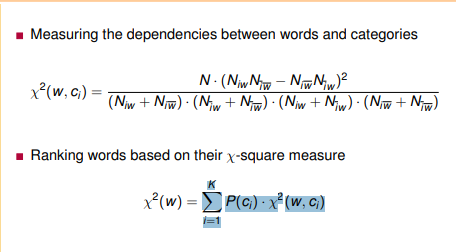

In [ ]:
def Chi_Square(N, Ni, Niw, Nw):
  N_i_w = N - Nw-Ni + Niw
  Ni_w = Ni - Niw
  N_iw = Nw - Niw
  Norm_term = (Niw+Ni_w) * (N_iw + N_i_w) * (Niw + N_iw)*(Ni_w + N_i_w)
  chi_s = N * ((Niw * N_i_w - Ni_w * N_iw) ** 2)/ Norm_term
  return chi_s

In [ ]:
vocab = dataset_loader_drive.dictionary.id2token
dataset_loader_drive.dictionary.num_docs
N  = len(X)
labels_counter = Counter(Y)
data = {}
words  = {}
for index in dataset_loader_drive.dictionary.dfs.keys():
    s = {}
    chi_s = 0
    for i in range(num_of_class):
        try:
          s[i] = class_words_stat[i][vocab[index]]
        except KeyError:
          s[i] = 0
        chi_s += (labels_counter[i]/N)*Chi_Square(N, labels_counter[i], s[i],dataset_loader_drive.dictionary.dfs[index])
    words[vocab[index]] =  chi_s

In [ ]:
d = pd.DataFrame({"words":words.keys(),
                  "count":words.values()})
d.to_excel("words_chi_score.xlsx")


In [ ]:
vocab = dataset_loader_drive.dictionary.id2token
dataset_loader_drive.dictionary.num_docs
N  = len(X)
labels_counter = Counter(Y)
data = {}
words  = {}
with pd.ExcelWriter("features_in_class.xlsx") as save_file:
  for i in range(num_of_class):
    s = {}
    chi_s = 0
    for index in dataset_loader_drive.dictionary.dfs.keys():
        try:
          s[i] = class_words_stat[i][vocab[index]]
        except KeyError:
          s[i] = 0
        chi_s = (Chi_Square(N, labels_counter[i], s[i],dataset_loader_drive.dictionary.dfs[index]))
        words[vocab[index]] =  chi_s
    pd.DataFrame({"word":words.keys(),"score":words.values()}).to_excel(save_file, sheet_name = str(id_2_labels[i]))

In [ ]:
# len(np.array(dataset_loader_drive.X)[:,1])
from collections import Counter
print(Counter(Y))

Counter({1: 1530, 8: 1182, 0: 1084, 2: 767, 4: 702, 3: 573, 5: 533, 13: 367, 9: 358, 11: 299, 15: 216, 10: 206, 12: 196, 6: 107, 7: 102, 14: 87})


# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import sklearn.metrics as mt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd
import numpy as np


In [ ]:
dataset_len =  len(X)
len(Y)

8309

In [ ]:
x_train,x_test, y_train, y_test = X[:int(0.8*dataset_len)], X[int(0.8*dataset_len):], Y[:int(0.8*dataset_len)], Y[int(0.8*dataset_len):]
text_test = Text[int(0.8*dataset_len):]
text_train =  Text[:int(0.8*dataset_len)]
print(len(y_train), len(y_test))
svm_model = SVC(kernel="rbf")
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print(mt.classification_report(y_test,y_pred,labels= [i for i in range(0, num_of_class)]))
print(mt.confusion_matrix(y_test,y_pred,labels= [i for i in range(0, num_of_class)]))
# for p,t,m in zip(y_pred,y_test,text_test):
#   print(p,t,m)
pd.DataFrame({"message":text_test,"true":y_test,"predict":y_pred}).to_excel("svm_label_result.xlsx")

In [ ]:
knn = KNeighborsClassifier(3)
knn.fit(x_train, y_train)
print(mt.classification_report(y_test,knn.predict(x_test),labels= [i for i in range(0,num_of_class)]))
for y,x,t in zip(y_test[:100],x_test[:100], text_test[:100]):
    print(y,t)
    y_pred = knn.kneighbors([x],3)
    for i in y_pred[1][0]:
      print(y_train[i],text_train[i])
    print("********************************************************")



# How our data embeddings scatter ?


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8309 samples in 0.001s...
[t-SNE] Computed neighbors for 8309 samples in 3.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8309
[t-SNE] Computed conditional probabilities for sample 2000 / 8309
[t-SNE] Computed conditional probabilities for sample 3000 / 8309
[t-SNE] Computed conditional probabilities for sample 4000 / 8309
[t-SNE] Computed conditional probabilities for sample 5000 / 8309
[t-SNE] Computed conditional probabilities for sample 6000 / 8309
[t-SNE] Computed conditional probabilities for sample 7000 / 8309
[t-SNE] Computed conditional probabilities for sample 8000 / 8309
[t-SNE] Computed conditional probabilities for sample 8309 / 8309
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.737251
[t-SNE] KL divergence after 1000 iterations: 2.395265


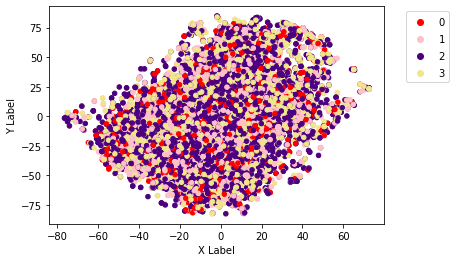

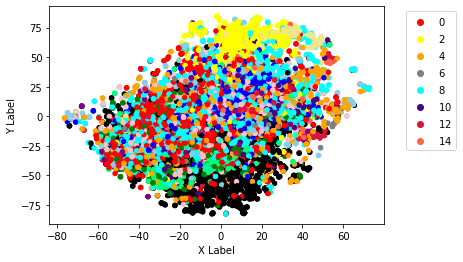

In [ ]:
from  sklearn.cluster import KMeans
kmean = KMeans(4
               )
kmean.fit(X)
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(np.array(dataset_loader_drive.X))
# data ={}
# data["ID"] = [i for i in range(len(kmean.labels_))]
# data["Label"] = kmean.labels_
# for i in range(1,4):
#   data[i] = z[:,i-1]
# data = pd.DataFrame(data)

data ={}
data["ID"] = [i for i in range(len(dataset_loader_drive.Y))]
data["Label"] = dataset_loader_drive.Y
for i in range(1,3):
  data[i] = z[:,i-1]
data = pd.DataFrame(data)
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# generate data
n = 200
x = z[:,0]
y = z[:,1]


# axes instance
# fig = plt.figure(figsize=(6,6))
# ax = Axes3D(fig)
# fig.add_axes(ax)

# get colormap from seaborn
cmap = ["red", "black",
        "yellow","blue",
        "orange", "pink",
        "gray", "purple",
        "cyan","green",
        "indigo", "springgreen",
        "crimson", "skyblue",
        "tomato","khaki" ]
cmap = ListedColormap(cmap)
# plot
sc = plt.scatter(x, y, s=20, c=kmean.labels_
                ,  cmap=cmap, alpha=1)
plt.xlabel('X Label')
plt.ylabel('Y Label')
# ax.set_zlabel('Z Label')



# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()
# save
plt.savefig("scatter_hue", bbox_inches='tight')
sc = plt.scatter(x, y, s=20, c=data["Label"]

                ,  cmap=cmap, alpha=1)
plt.xlabel('X Label')
plt.ylabel('Y Label')
# ax.set_zlabel('Z Label')



# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()
# for i in range(1,4):
#   data[i] = z[:,i-1]
# data = pd.DataFrame(data)
# import re, seaborn as sns
# import numpy as np

# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap

# # generate data
# n = 200
# x = z[:,0]
# y = z[:,1]
# v = z[:,2]

# # axes instance
# fig = plt.figure(figsize=(6,6))
# ax = Axes3D(fig)
# fig.add_axes(ax)

# # get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# # plot
# sc = ax.scatter(x, y, v, s=40, c=kmean.labels_
#                 ,  cmap=cmap, alpha=1)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')



# # legend
# plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# # save
# plt.savefig("scatter_hue", bbox_inches='tight')

In [ ]:
x_train,x_test, y_train, y_test = z[:int(0.8*dataset_len)], X[int(0.8*dataset_len):], Y[:int(0.8*dataset_len)], Y[int(0.8*dataset_len):]
text_test = Text[int(0.8*dataset_len):]
text_train =  Text[:int(0.8*dataset_len)]
print(len(y_train), len(y_test))
svm_model = SVC(kernel="rbf")
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print(mt.classification_report(y_test,y_pred,labels= [ 1, 2, 8]))
print(mt.confusion_matrix(y_test,y_pred,labels= [0, 1, 2, 8]))
# for p,t,m in zip(y_pred,y_test,text_test):
#   print(p,t,m)
pd.DataFrame({"message":text_test,"true":y_test,"predict":y_pred}).to_excel("svm_label_result.xlsx")

In [ ]:
tsne = TSNE(n_components=
            3, verbose=1, random_state=123)
z = tsne.fit_transform(np.array(dataset_loader_drive.X))

In [ ]:

data ={}
data["ID"] =[i for i in range(len(dataset_loader_drive.Y))]
data["Label"] = dataset_loader_drive.Y
for i in range(1,4):
  data[i] = z[:,i-1]
data = pd.DataFrame(data)

In [ ]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# generate data
n = 200
x = z[:,0]
y = z[:,1]
v = z[:,2]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn


cmap = ["red", "black",
        "yellow","blue",
        "orange", "pink",
        "gray", "purple",
        "cyan","green",
        "indigo", "springgreen",
        "crimson", "skyblue",
        "tomato","khaki" ]
cmap = ListedColormap(cmap)
print(sns.color_palette("husl", 256))


# plot
sc = ax.scatter(x, y, v, s=5, c=data["Label"] ,  cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

In [ ]:
l = len(dataset_loader_drive.X)
# l = 1000

In [ ]:
import math
seprate_index = math.floor(0.8*l)
message_dataset_train = Message_Dataset(X[:seprate_index], Y[:seprate_index])
message_dataset_valid = Message_Dataset(X[seprate_index:l], Y[seprate_index:l])

In [ ]:
int(0.2*dataset_len)

In [ ]:
data_loader_train = DataLoader(message_dataset_train,batch_size=16)
data_loader_valid = DataLoader(message_dataset_valid,batch_size=int(0.2*dataset_len)+1)

# MLP Classification Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data



from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
# class Messages_Classifier(nn.Module):
#     def __init__(self, vocab_size, embedding_size,num_of_class,max_len):
#       super(Messages_Classifier, self).__init__()
#       self.embedding = nn.Embedding(vocab_size, embedding_size)
#       self.fully_connected1= nn.Linear(embedding_size* max_len, 500)
#       self.dropout = nn.Dropout(0.3)
#       self.fully_connected2= nn.Linear(500, 300)
#       self.fully_connected3= nn.Linear(300, num_of_class)

#     def forward(self,x):
#       batch_size,input_l = x.size()
#       embed = self.embedding(x)
#       h1 = self.fully_connected1(embed.view(batch_size, -1))
#       d= self.dropout(h1)
#       h2 = self.fully_connected2(F.relu(d))
#       h3 = self.fully_connected3(F.relu(h2))
#       return h3
class Messages_Classifier(nn.Module):
    def __init__(self,  embedding_size,num_of_class,max_len):
      super(Messages_Classifier, self).__init__()
      # self.embedding = nn.Embedding(vocab_size, embedding_size)
      self.fully_connected1= nn.Linear(50, 100)
      self.dropout = nn.Dropout(0.2)
      self.fully_connected2= nn.Linear(100, 40)
      self.fully_connected3= nn.Linear(40, num_of_class)

    def forward(self,x):
      batch_size,input_l = x.size()
      # embed = self.embedding(x)
      h1 = self.fully_connected1(x)
      d= self.dropout(h1)
      h2 = self.fully_connected2(F.relu(d))
      h3 = self.fully_connected3(F.relu(h2))
      return h3

In [ ]:
model = Messages_Classifier(100,num_of_class,dataset_loader_drive.max_len)


In [ ]:
print(model
      )

In [ ]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)
# print(optimizer.lr)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_fun = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fun = loss_fun.to(device)

In [ ]:
def accuracy_score(y_pred, y ):
    top_pred = y_pred.argmax(1, keepdim=True)
    # print(metrics.confusion_matrix(top_pred.cpu(),y.cpu()))
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True


In [ ]:
def train(model,train_data, optimizer, loss_fun):
   epoch_loss = 0
   epoch_acc = 0
   model.train()
   for (text, label) in tqdm(train_data):

      optimizer.zero_grad()

      x = text.to(device)
      y = label.to(device)

      output= model(x.float())

      loss = loss_fun(output,y)

      acc= accuracy_score(output, y)
      # print("**")
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  # if index == 1:
    #   print(len(iterator))
    #   print(metrics.classification_report(top_pred.cpu(),y.cpu(),labels = [i for i in range(20)]))
    #   print(metrics.confusion_matrix(top_pred.cpu(),y.cpu(),labels = [i for i in range(20)]))
   return epoch_loss / len(train_data), epoch_acc / len(train_data)


In [ ]:
def evaluate(model, iterator, criterion, device,index=0):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)
            print(x.shape)
            y_pred = model(x.float())

            loss = criterion(y_pred, y)

            acc = accuracy_score(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    top_pred = y_pred.argmax(1, keepdim=True)
    # if index == 1:
    #   print(len(iterator))
    #   print(metrics.classification_report(top_pred.cpu(),y.cpu(),labels = [i for i in range(20)]))
    #   print(metrics.confusion_matrix(top_pred.cpu(),y.cpu(),labels = [i for i in range(20)]))
    return epoch_loss / len(iterator), epoch_acc / len(iterator), top_pred, y

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def plot_confusion_matrix(con_matrix):
  df_cm = pd.DataFrame(con_matrix, range(num_of_class), range(num_of_class))
# plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
  plt.show()

In [ ]:
EPOCHS = 500
early_stopping = EarlyStopping(tolerance=5, min_delta=0.6)
best_valid_loss = float('inf')
loss_per_epoch_train = []
loss_per_epoch_valid = []
for epoch in tqdm(range(EPOCHS)):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, data_loader_train, optimizer, loss_fun)
    valid_loss, valid_acc ,y_pred, y  = evaluate(model, data_loader_valid, loss_fun, device, 1 if epoch == EPOCHS-1 else 0)
    loss_per_epoch_train.append(train_loss)
    loss_per_epoch_valid.append(valid_loss)
    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      data_loader_train = DataLoader(message_dataset_train,batch_size=int(l*0.8)+1,shuffle=True)
      valid_loss, valid_acc,y_pred, y  = evaluate(model, data_loader_train, loss_fun, device, 1 )
      print(mt.classification_report(y.cpu(),y_pred.cpu(),labels = [i for i in range(num_of_class)]))
      print(plot_confusion_matrix(con_matrix=mt.confusion_matrix(y.cpu(),y_pred.cpu(),labels = [i for i in range(num_of_class)])))

      valid_loss, valid_acc,y_pred, y  = evaluate(model, data_loader_valid, loss_fun, device, 1 )
      print(mt.classification_report(y.cpu(),y_pred.cpu(),labels = [i for i in range(num_of_class)]))
      print(plot_confusion_matrix(con_matrix=mt.confusion_matrix(y.cpu(),y_pred.cpu(),labels = [i for i in range(num_of_class)])))
      print(epoch)
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      break
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
        print(mt.classification_report(y.cpu(),y_pred.cpu(),labels = [i for i in range(num_of_class)]))
    end_time = time.monotonic()
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
plt.plot(loss_per_epoch_train)
plt.plot(loss_per_epoch_valid)
plt.show()

In [ ]:
y_pred.cpu().numpy().reshape(1,-1).squeeze()

In [ ]:

pd.DataFrame({"message":Text[int(dataset_len * 0.8):],"true":y.cpu().numpy().reshape(1,-1).squeeze(),"predict":y_pred.cpu().numpy().reshape(1,-1).squeeze()}).to_excel("ANN_label_result.xlsx")